# mobilenet


In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [2]:
model=tf.keras.applications.mobilenet.MobileNet()

In [3]:
model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [4]:
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', LABELS_URL)
labels = np.array(
    open(labels_path).read().splitlines()
)[1:]

In [5]:
labels

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich',
       'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting',
       'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel',
       'kite', 'bald eagle', 'vulture', 'great grey owl',
       'European fire salamander', 'common newt', 'eft',
       'spotted salamander', 'axolotl', 'bullfrog', 'tree frog',
       'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle',
       'terrapin', 'box turtle', 'banded gecko', 'common iguana',
       'American chameleon', 'whiptail', 'agama', 'frilled lizard',
       'alligator lizard', 'Gila monster', 'green lizard',
       'African chameleon', 'Komodo dragon', 'African crocodile',
       'American alligator', 'triceratops', 'thunder snake',
       'ringneck snake', 'hognose snake', 'green snake', 'king snake',
       'garter snake', 'water snake', 'vine snake', 'night snake',
     

In [6]:
labels_path

'C:\\Users\\Asus\\.keras\\datasets\\ImageNetLabels.txt'

# Loading the image


In [7]:
def load_image(image_path):
    return tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224))



In [8]:
#converting image into 2 d array
def img_arr(img):
    return tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32)

In [16]:
#displaying the image
def display_img(img_np):
    plt.figure()
    plt.imshow(img_np)


In [17]:
import pathlib
TEST_IMAGES_DIR_PATH = pathlib.Path('datasets/data4mobilenet')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[WindowsPath('datasets/data4mobilenet/airplane.jpg'),
 WindowsPath('datasets/data4mobilenet/bird.jpg'),
 WindowsPath('datasets/data4mobilenet/cat.37.jpg'),
 WindowsPath('datasets/data4mobilenet/dog.67.jpg'),
 WindowsPath('datasets/data4mobilenet/fish.jpg'),
 WindowsPath('datasets/data4mobilenet/liger.jpg'),
 WindowsPath('datasets/data4mobilenet/lizARd.jpg')]

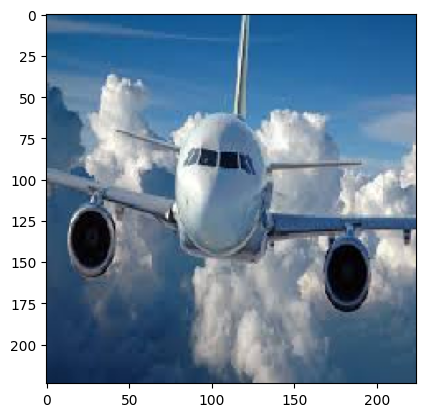

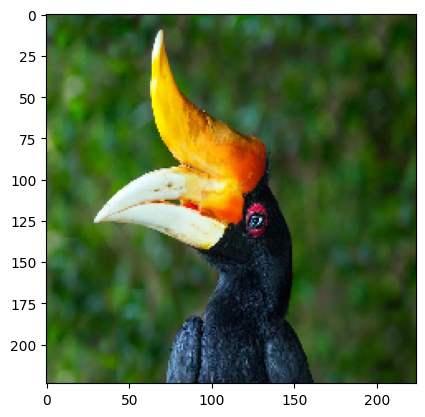

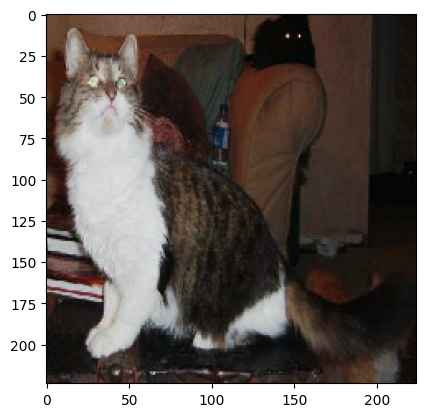

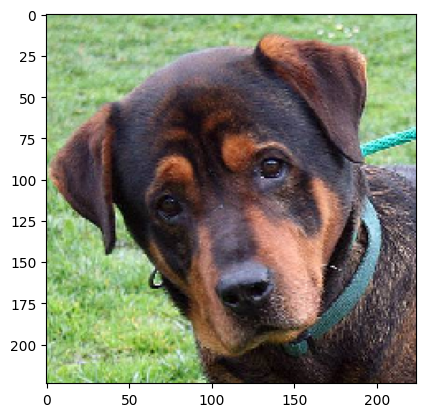

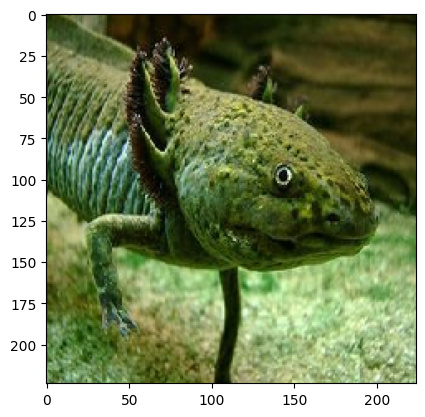

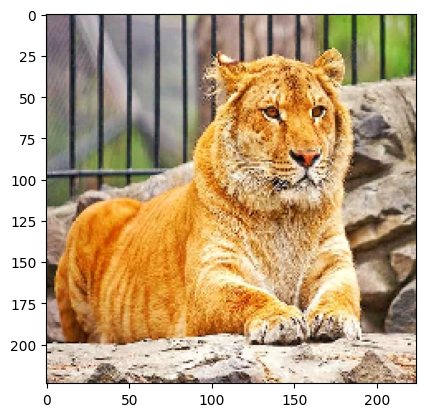

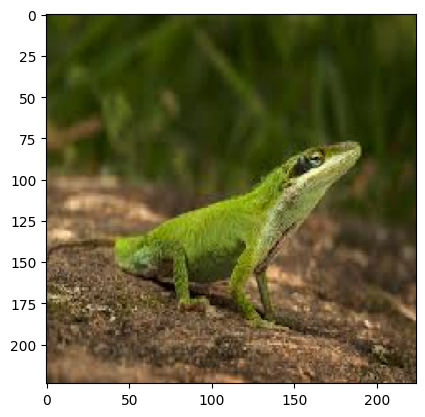

In [18]:
test_images = []
for images in TEST_IMAGE_PATHS:
    test_image=load_image(images)
    img_array=img_arr(test_image)
    test_images.append(img_array)
    display_img(img_array)

In [19]:
#imagearray for airplane
test_images[0]

array([[[ 39,  92, 134],
        [ 38,  91, 133],
        [ 34,  87, 131],
        ...,
        [ 17,  82, 140],
        [ 15,  80, 138],
        [ 15,  80, 138]],

       [[ 50,  99, 140],
        [ 49,  98, 139],
        [ 45,  94, 135],
        ...,
        [ 18,  83, 141],
        [ 16,  81, 139],
        [ 16,  81, 139]],

       [[ 65, 107, 145],
        [ 65, 107, 145],
        [ 62, 104, 142],
        ...,
        [ 18,  83, 141],
        [ 17,  82, 140],
        [ 17,  82, 140]],

       ...,

       [[ 16,  40,  74],
        [ 15,  39,  73],
        [ 15,  39,  73],
        ...,
        [ 44,  79, 109],
        [ 44,  79, 109],
        [ 44,  79, 109]],

       [[ 15,  39,  73],
        [ 15,  39,  73],
        [ 14,  38,  72],
        ...,
        [ 43,  78, 108],
        [ 44,  79, 109],
        [ 44,  79, 109]],

       [[ 15,  39,  73],
        [ 15,  39,  73],
        [ 14,  38,  72],
        ...,
        [ 43,  78, 108],
        [ 44,  79, 109],
        [ 44,  79, 109]]

## We need to preprocess images before using them with the model. By applying a preprocess_input() function to the image it will scale pixels between -1 and 1 and also will add additional batch dimension.

In [20]:
def image_preprocess(image_array):
    return tf.keras.applications.mobilenet_v2.preprocess_input(image_array[tf.newaxis, ...])

In [21]:
test_images_preprocessed = []
for test_image in test_images:
    test_image_preprocessed = image_preprocess(test_image)
    test_images_preprocessed.append(test_image_preprocessed)

In [22]:
print('Image shape before preprocessing:', test_images[0].shape)
print('Image shape after preprocessing:', test_images_preprocessed[0].shape)

Image shape before preprocessing: (224, 224, 3)
Image shape after preprocessing: (1, 224, 224, 3)


In [23]:

print(test_images_preprocessed[1])

[[[[-0.60784316 -0.21568626 -0.77254903]
   [-0.6156863  -0.26274508 -0.7882353 ]
   [-0.5764706  -0.24705881 -0.7490196 ]
   ...
   [-0.78039217 -0.60784316 -0.9137255 ]
   [-0.78039217 -0.60784316 -0.90588236]
   [-0.8039216  -0.6392157  -0.8980392 ]]

  [[-0.58431375 -0.18431371 -0.70980394]
   [-0.5686275  -0.20784312 -0.70980394]
   [-0.5764706  -0.23137254 -0.69411767]
   ...
   [-0.78039217 -0.60784316 -0.9137255 ]
   [-0.78039217 -0.60784316 -0.90588236]
   [-0.7882353  -0.62352943 -0.88235295]]

  [[-0.5686275  -0.16862744 -0.6313726 ]
   [-0.5529412  -0.18431371 -0.6156863 ]
   [-0.5529412  -0.20784312 -0.62352943]
   ...
   [-0.77254903 -0.6        -0.90588236]
   [-0.77254903 -0.6        -0.8980392 ]
   [-0.7647059  -0.6        -0.85882354]]

  ...

  [[-0.27843136 -0.0745098  -0.27058822]
   [-0.3098039  -0.09019607 -0.38823527]
   [-0.32549018 -0.09803921 -0.4588235 ]
   ...
   [-0.654902   -0.4823529  -0.8509804 ]
   [-0.6627451  -0.47450978 -0.8666667 ]
   [-0.6784314  

# classify the images

In [24]:
def get_tags(probs, labels, max_classes = 5, prob_threshold = 0.01):
    probs_mask = probs > prob_threshold
    probs_filtered = probs[probs_mask] * 100
    labels_filtered = labels[probs_mask]
    
    sorted_index = np.flip(np.argsort(probs_filtered))
    labels_filtered = labels_filtered[sorted_index][:max_classes]
    probs_filtered = probs_filtered[sorted_index][:max_classes].astype(int)
    
    tags = ''
    for i in range(0, len(labels_filtered)):
        tags = tags + labels_filtered[i] + ' (' + str(probs_filtered[i]) + '%), ' 

    return tags, labels_filtered, probs_filtered 

In [25]:
TEST_IMAGE_INDEX = 2

In [26]:
result = model(test_images_preprocessed[TEST_IMAGE_INDEX])#output tensor=model(input tensor) is somewhat similar to model.predict

In [27]:
result

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[1.32662888e-06, 7.11169832e-06, 3.24672186e-07, 1.04218351e-07,
        2.19109836e-07, 3.82900271e-06, 8.55670166e-08, 9.41739199e-06,
        4.85726059e-06, 1.50937221e-05, 7.64325250e-07, 5.61732953e-08,
        7.54158975e-08, 4.27318412e-07, 3.16233191e-08, 3.84123631e-08,
        3.40772167e-05, 2.47268389e-07, 2.33971195e-06, 1.51334530e-06,
        4.25696135e-06, 4.49632239e-07, 5.17726176e-06, 3.54221106e-06,
        3.10126865e-07, 1.87955413e-06, 2.97374470e-07, 4.45565092e-07,
        4.90084290e-07, 1.82722101e-06, 1.55834840e-07, 2.37874023e-08,
        8.79866704e-08, 1.97405754e-07, 2.01716063e-07, 1.71313026e-08,
        1.24778865e-07, 1.62996713e-07, 3.55647359e-07, 8.55884821e-08,
        5.21000594e-08, 3.19972884e-07, 6.60437081e-07, 9.83084306e-07,
        6.30615250e-06, 3.97445046e-06, 7.44885327e-08, 7.95584640e-07,
        1.18780150e-07, 1.30632628e-07, 3.34409890e-07, 2.64296432e-05,
        9.718

In [28]:
result.shape#(1,1000) 1 means image number or batches 1000 means  no of classess in image net


TensorShape([1, 1000])

In [29]:
#convert tensor into numpy as 
np_result = result.numpy()[0]

In [30]:
np_result.shape

(1000,)

In [31]:
np_result

array([1.32662888e-06, 7.11169832e-06, 3.24672186e-07, 1.04218351e-07,
       2.19109836e-07, 3.82900271e-06, 8.55670166e-08, 9.41739199e-06,
       4.85726059e-06, 1.50937221e-05, 7.64325250e-07, 5.61732953e-08,
       7.54158975e-08, 4.27318412e-07, 3.16233191e-08, 3.84123631e-08,
       3.40772167e-05, 2.47268389e-07, 2.33971195e-06, 1.51334530e-06,
       4.25696135e-06, 4.49632239e-07, 5.17726176e-06, 3.54221106e-06,
       3.10126865e-07, 1.87955413e-06, 2.97374470e-07, 4.45565092e-07,
       4.90084290e-07, 1.82722101e-06, 1.55834840e-07, 2.37874023e-08,
       8.79866704e-08, 1.97405754e-07, 2.01716063e-07, 1.71313026e-08,
       1.24778865e-07, 1.62996713e-07, 3.55647359e-07, 8.55884821e-08,
       5.21000594e-08, 3.19972884e-07, 6.60437081e-07, 9.83084306e-07,
       6.30615250e-06, 3.97445046e-06, 7.44885327e-08, 7.95584640e-07,
       1.18780150e-07, 1.30632628e-07, 3.34409890e-07, 2.64296432e-05,
       9.71898226e-06, 6.50995560e-08, 6.53904181e-07, 2.57673562e-08,
      

In [32]:
tags, labels_filtered, probs_filtered = get_tags(np_result, labels)

print('probs_filtered:', probs_filtered)
print('labels_filtered:', labels_filtered)
print('tags:', tags)

probs_filtered: [39 11 10  5  3]
labels_filtered: ['tabby' 'tiger cat' 'Egyptian cat' 'Persian cat' 'Cardigan']
tags: tabby (39%), tiger cat (11%), Egyptian cat (10%), Persian cat (5%), Cardigan (3%), 


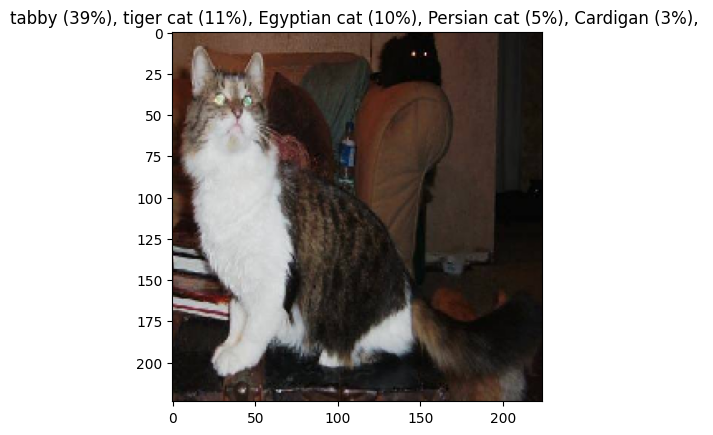

In [33]:
plt.figure()
plt.title(tags)
plt.imshow(test_images[TEST_IMAGE_INDEX])

In [34]:
np.array(test_images)

array([[[[ 39,  92, 134],
         [ 38,  91, 133],
         [ 34,  87, 131],
         ...,
         [ 17,  82, 140],
         [ 15,  80, 138],
         [ 15,  80, 138]],

        [[ 50,  99, 140],
         [ 49,  98, 139],
         [ 45,  94, 135],
         ...,
         [ 18,  83, 141],
         [ 16,  81, 139],
         [ 16,  81, 139]],

        [[ 65, 107, 145],
         [ 65, 107, 145],
         [ 62, 104, 142],
         ...,
         [ 18,  83, 141],
         [ 17,  82, 140],
         [ 17,  82, 140]],

        ...,

        [[ 16,  40,  74],
         [ 15,  39,  73],
         [ 15,  39,  73],
         ...,
         [ 44,  79, 109],
         [ 44,  79, 109],
         [ 44,  79, 109]],

        [[ 15,  39,  73],
         [ 15,  39,  73],
         [ 14,  38,  72],
         ...,
         [ 43,  78, 108],
         [ 44,  79, 109],
         [ 44,  79, 109]],

        [[ 15,  39,  73],
         [ 15,  39,  73],
         [ 14,  38,  72],
         ...,
         [ 43,  78, 108],
        

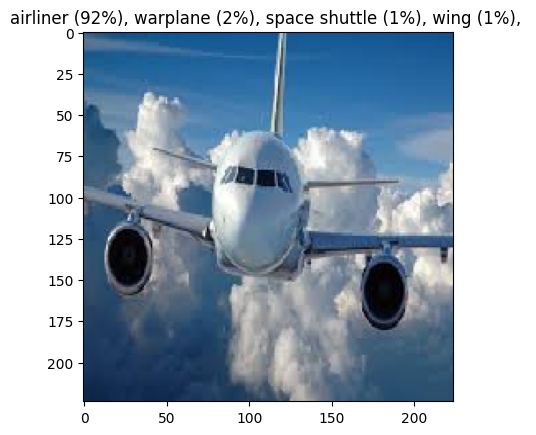

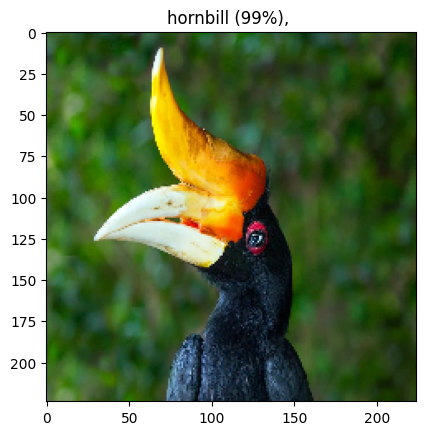

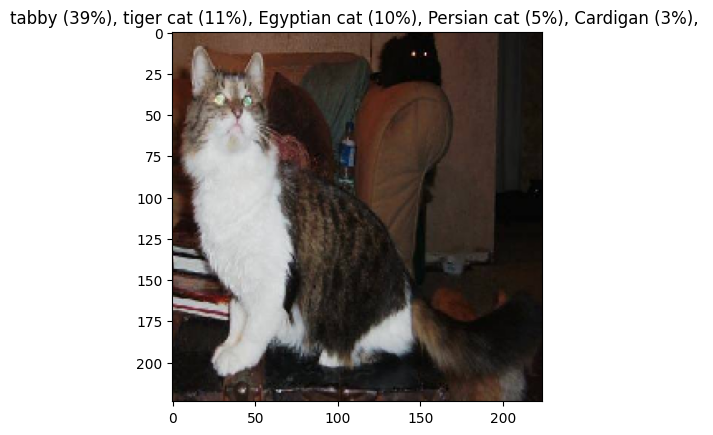

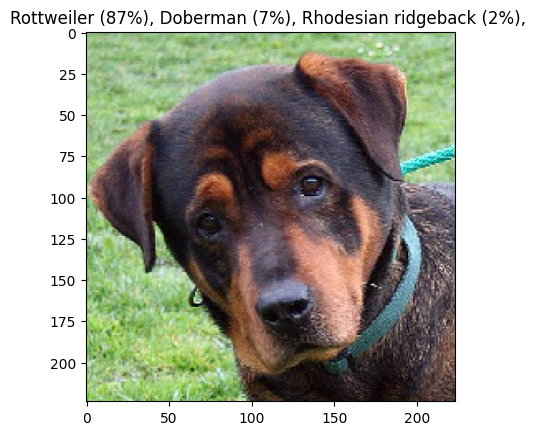

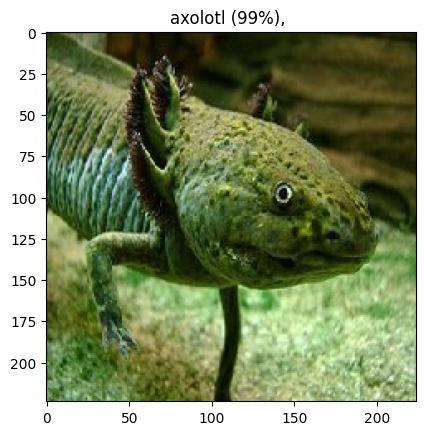

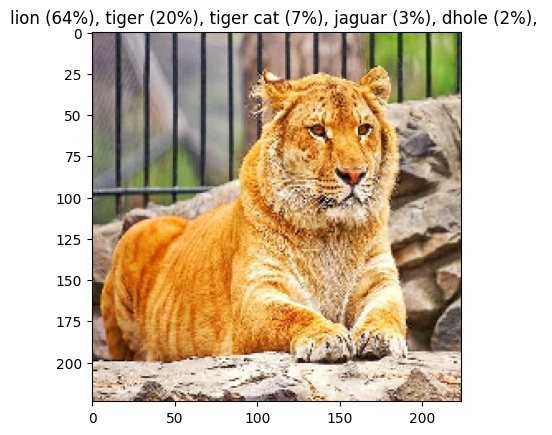

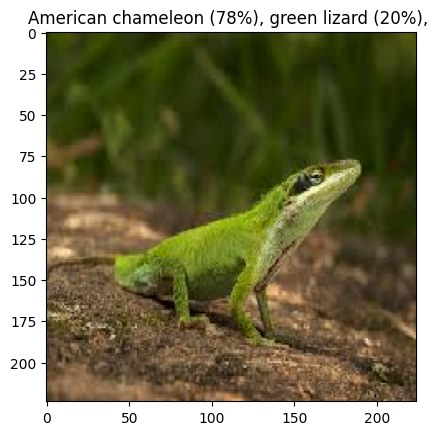

In [35]:
# classify all the available images
for image_index in range(0, len(test_images)):
    test_image = test_images[image_index]
    test_image_preprocessed = test_images_preprocessed[image_index]
    outputTensor = model(test_image_preprocessed)#test_image_preprocessed is input tensor
    tags, labels_filtered, probs_filtered = get_tags(outputTensor.numpy()[0], labels)
    plt.show()
    plt.title(tags)
    plt.imshow(test_image)
    